# NOAA extreme weather events
The [National Oceanic and Atmospheric Administration](https://en.wikipedia.org/wiki/National_Oceanic_and_Atmospheric_Administration) has a database of extreme weather events that contains lots of detail for every year ([Link](https://www.climate.gov/maps-data/dataset/severe-storms-and-extreme-events-data-table)).  In this notebook I will create map files for individual weather events, mapped to their coordinates.

In [1]:
import pandas as pd
import numpy as np
import random
import geopandas
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)  # Unlimited columns

# Custom function for displaying the shape and head of a dataframe
def display(df, n=5):
    print(df.shape)
    return df.head(n)

# Get map of US counties

In [2]:
# Import a shape file with all the counties in the US.
# Note how it doesn't include all the same territories as the 
# quake contour map.
counties = geopandas.read_file('../data_input/1_USCounties/')

# Turn state codes from strings to integers
for col in ['STATE_FIPS', 'CNTY_FIPS', 'FIPS']:
    counties[col] = counties[col].astype(int)

# Process NOAA data for one year only
As a starting point that I'll generalize later.

In [3]:
# Get NOAA extreme weather event data for one year
df1 = pd.read_csv('../data_local/NOAA/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')
print(df1.shape)
print(df1.columns)
df1.head(2)

(62169, 51)
Index(['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'END_YEARMONTH',
       'END_DAY', 'END_TIME', 'EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS',
       'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME',
       'WFO', 'BEGIN_DATE_TIME', 'CZ_TIMEZONE', 'END_DATE_TIME',
       'INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT',
       'DEATHS_INDIRECT', 'DAMAGE_PROPERTY', 'DAMAGE_CROPS', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION', 'BEGIN_LAT', 'BEGIN_LON', 'END_LAT', 'END_LON',
       'EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'],
      dtype='object')


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,201806,6,1810,201806,6,1810,125578,753161,NEBRASKA,31,2018,June,Hail,C,69,GARDEN,LBF,06-JUN-18 18:10:00,MST-7,06-JUN-18 18:10:00,0,0,0,0,0.00K,0.00K,Public,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,N,OSHKOSH,36.0,N,OSHKOSH,41.93,-102.21,41.93,-102.21,Severe storms developed in the Nebraska Panhan...,Hail predominately penny size with some quarte...,CSV
1,201806,6,1741,201806,6,1741,125578,753160,NEBRASKA,31,2018,June,Hail,C,161,SHERIDAN,LBF,06-JUN-18 17:41:00,MST-7,06-JUN-18 17:41:00,0,0,0,0,0.00K,0.00K,Trained Spotter,1.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NW,BINGHAM,1.0,NW,BINGHAM,42.03,-102.10,42.03,-102.10,Severe storms developed in the Nebraska Panhan...,Hail mainly quarter size with some half dollar...,CSV


In [14]:
# Extract only a few useful columns
df2 = df1[['TOR_F_SCALE','EVENT_TYPE','BEGIN_LAT','BEGIN_LON']].copy()

# Remove any rows with null coordinates
df2 = df2.dropna(subset=['BEGIN_LAT','BEGIN_LON'])

# Create geoDF of all the points 
df3 = geopandas.GeoDataFrame(
    df2, geometry=geopandas.points_from_xy(df2.BEGIN_LON, df2.BEGIN_LAT))

# Trim the list of events to only include those that happened within one of our official counties.
df4 = geopandas.sjoin(df3, counties, how='left', op='within').dropna(subset=['FIPS'])

# Drop useless columns
df4 = df4[['TOR_F_SCALE','EVENT_TYPE','geometry']]

# Add new columns for event categories


flood_types =['Flood','Flash Flood','Coastal Flood',
             'Storm Surge/Tide','Lakeshore Flood','Debris Flow']  
df4['Flood'] = df4['EVENT_TYPE'].isin(flood_types)



storm_types = ['Thunderstorm Wind','Marine Thunderstorm Wind','Marine High Wind',
               'High Wind','Funnel Cloud','Dust Storm',
             'Strong Wind','Dust Devil','Tropical Depression','Lightning',
            'Tropical Storm','High Surf','Heavy Rain','Hail','Marine Hail',
              'Marine Strong Wind','Waterspout']
df4['Storm'] = df4['EVENT_TYPE'].isin(storm_types)


df4['Tornado'] = df4['EVENT_TYPE'].isin(['Tornado'])


# Reorganize columns
type_columns = ['Storm','Flood','Tornado']
df4 = df4[['TOR_F_SCALE','EVENT_TYPE','geometry'] + type_columns]

display(df4)

(35940, 6)


,TOR_F_SCALE,EVENT_TYPE,geometry,Storm,Flood,Tornado
0,NaN,Hail,POINT (-102.21 41.93),True,False,False
1,NaN,Hail,POINT (-102.1 42.03),True,False,False
2,NaN,Thunderstorm Wind,POINT (-72.8699 44.9565),True,False,False
3,NaN,Thunderstorm Wind,POINT (-72.7474 44.7316),True,False,False
4,EF0,Tornado,POINT (-101.79 40.9),False,False,True


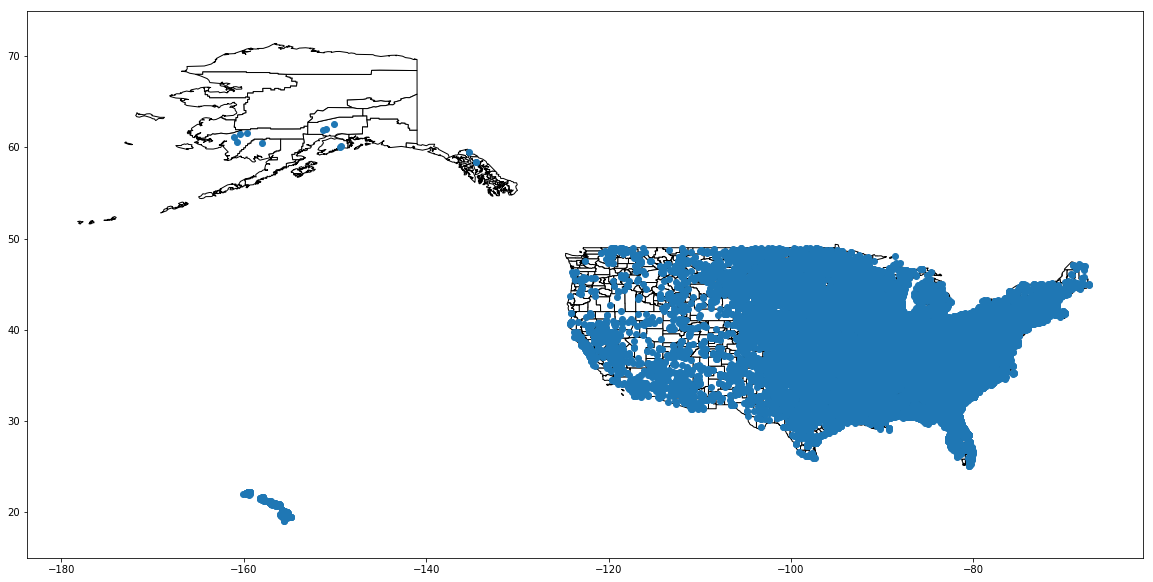

In [15]:
# Plot over a map of US counties
fig, ax = plt.subplots(figsize=(20,20))
counties.plot(ax=ax, color='white', edgecolor='black');
df4.plot(ax=ax, marker='o')
# ax.set_xlim(-125,-114)
ax.set_ylim(15,75)
plt.show()

## NOAA file processing function
Generalize the previous operations so they can apply to the data for any year

In [16]:
def process_noaa(filepath):
    """
    Process one year of NOAA Extreme weather events. Requires
    the list of official counties and the list of official weather
    event types.
    
    Inputs
    ------
    filepath (string) : file path for the list of events from one year.
    
    
    Outputs
    -------
    result (pandas.DataFrame) : Dataframe each event for that year, with
                                boolean columns for each event category.
    
    """
    
    df1 = pd.read_csv(filepath)
    
    # Extract only a few useful columns
    df2 = df1[['TOR_F_SCALE','EVENT_TYPE','BEGIN_LAT','BEGIN_LON']].copy()

    # Remove any rows with null coordinates
    df2 = df2.dropna(subset=['BEGIN_LAT','BEGIN_LON'])

    # Create geoDF of all the points 
    df3 = geopandas.GeoDataFrame(
        df2, geometry=geopandas.points_from_xy(df2.BEGIN_LON, df2.BEGIN_LAT))

    # Trim the list of events to only include those that happened within one of our official counties.
    df4 = geopandas.sjoin(df3, counties, how='left', op='within').dropna(subset=['FIPS'])

    # Drop useless columns
    df4 = df4[['TOR_F_SCALE','EVENT_TYPE','geometry']]

    # Add new columns for event categories


    flood_types =['Flood','Flash Flood','Coastal Flood',
                 'Storm Surge/Tide','Lakeshore Flood','Debris Flow']  
    df4['Flood'] = df4['EVENT_TYPE'].isin(flood_types)



    storm_types = ['Thunderstorm Wind','Marine Thunderstorm Wind','Marine High Wind',
                   'High Wind','Funnel Cloud','Dust Storm',
                 'Strong Wind','Dust Devil','Tropical Depression','Lightning',
                'Tropical Storm','High Surf','Heavy Rain','Hail','Marine Hail',
                  'Marine Strong Wind','Waterspout']
    df4['Storm'] = df4['EVENT_TYPE'].isin(storm_types)


    df4['Tornado'] = df4['EVENT_TYPE'].isin(['Tornado'])


    # Reorganize columns
    type_columns = ['Storm','Flood','Tornado']
    df4 = df4[['TOR_F_SCALE','EVENT_TYPE','geometry'] + type_columns]
    
    # Add a column for the year of this file
    year = int(filepath[49:53])
    df4['year'] = year

    return df4

In [17]:
# Example
test_2018 = process_noaa('../data_local/NOAA/StormEvents_details-ftp_v1.0_d2018_c20190422.csv')
display(test_2018)

(35940, 7)


,TOR_F_SCALE,EVENT_TYPE,geometry,Storm,Flood,Tornado,year
0,NaN,Hail,POINT (-102.21 41.93),True,False,False,2018
1,NaN,Hail,POINT (-102.1 42.03),True,False,False,2018
2,NaN,Thunderstorm Wind,POINT (-72.8699 44.9565),True,False,False,2018
3,NaN,Thunderstorm Wind,POINT (-72.7474 44.7316),True,False,False,2018
4,EF0,Tornado,POINT (-101.79 40.9),False,False,True,2018


In [18]:
# These are the extreme weather events recorded in 2018
test_2018[type_columns].sum().sort_values(ascending=False)

Storm      25581
Flood       9131
Tornado     1228
dtype: int64

# Process all the available data

In [19]:
import glob
import os

# Read the CSV files for each year going back to 1996 (the first year 
# when many of these event types started being recorded)
path = '../data_local/NOAA/'
filenames = sorted(glob.glob(os.path.join(path, '*.csv')))
layers = []

# Aggregate the dataframes in a list
for name in filenames:
    year = int(name[49:53])
    print(f'Processing {year}')
    layers.append(process_noaa(name))

# Concatenate all these dataframes into a single dataframe
noaa = pd.concat(layers)

Processing 1996
Processing 1997
Processing 1998
Processing 1999
Processing 2000
Processing 2001
Processing 2002
Processing 2003
Processing 2004
Processing 2005
Processing 2006
Processing 2007
Processing 2008
Processing 2009
Processing 2010
Processing 2011
Processing 2012
Processing 2013
Processing 2014
Processing 2015
Processing 2016
Processing 2017
Processing 2018


In [20]:
display(noaa)

(731944, 7)


,TOR_F_SCALE,EVENT_TYPE,geometry,Storm,Flood,Tornado,year
2,NaN,Hail,POINT (-98.03 34.42),True,False,False,1996
5,NaN,Thunderstorm Wind,POINT (-97.15000000000001 31.55),True,False,False,1996
6,NaN,Thunderstorm Wind,POINT (-88.97 36.02),True,False,False,1996
41,NaN,Thunderstorm Wind,POINT (-89.06999999999999 40.53),True,False,False,1996
68,NaN,Thunderstorm Wind,POINT (-87.06999999999999 39.92),True,False,False,1996


In [21]:
# total events per type
noaa[type_columns].sum()

Storm      622110
Flood       78936
Tornado     30898
dtype: int64

In [57]:
# Aggregate event types into different geopandas dataframes.
storms = noaa[noaa['Storm']][['EVENT_TYPE','year','geometry']].reset_index(drop=True)
floods = noaa[noaa['Flood']][['EVENT_TYPE','year','geometry']].reset_index(drop=True)
tornadoes = noaa[noaa['Tornado']][['TOR_F_SCALE','year','geometry']].reset_index(drop=True)

storms.shape, floods.shape, tornadoes.shape

((622110, 3), (78936, 3), (30898, 3))

## Process tornado data
In 2007, the National Weather Service (NWS) switched their scale for measuring tornado intensity, from the Fujita (F) scale to the Enhanced Fujita (EF) scale.  I will lump them together here and just make a note for the user that the scale means something slightly different before and after 2007.  Also, I'll cast unknown magnitudes (EFU) as if they were EF0.

In [51]:
# Tornadoes by magnitude, using the NWS's original labels.
# Notice the two different scales and also a label for 'unknown'
tornadoes.TOR_F_SCALE.value_counts()

F0     9134
EF0    8512
EF1    5468
F1     3821
EF2    1579
F2     1221
EF3     444
F3      400
EFU     115
EF4     103
F4       80
EF5      14
F5        7
Name: TOR_F_SCALE, dtype: int64

In [66]:
# Function that extracts the scale level and sets unkwnown to zero.
def process_fujita(x):
    if x[-1] == 'U':
        return 0
    else:
        return int(x[-1])

tornadoes['intensity'] = tornadoes['TOR_F_SCALE'].apply(process_fujita)
tornadoes = tornadoes.drop(columns='TOR_F_SCALE')

display(tornadoes)

(30898, 3)


,year,geometry,intensity
0,1996,POINT (-89.87 36.18),1
1,1996,POINT (-90.97 34.55),1
2,1996,POINT (-92.31999999999999 30.57),1
3,1996,POINT (-86.97 40.5),0
4,1996,POINT (-96.15000000000001 33.72),2


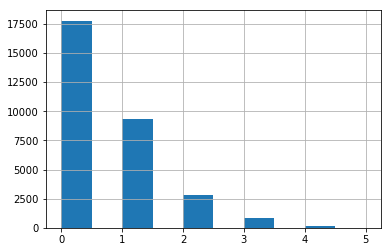

In [54]:
# Distribution of tornado intensities.
tornadoes.intensity.hist();

# Visualizing the data

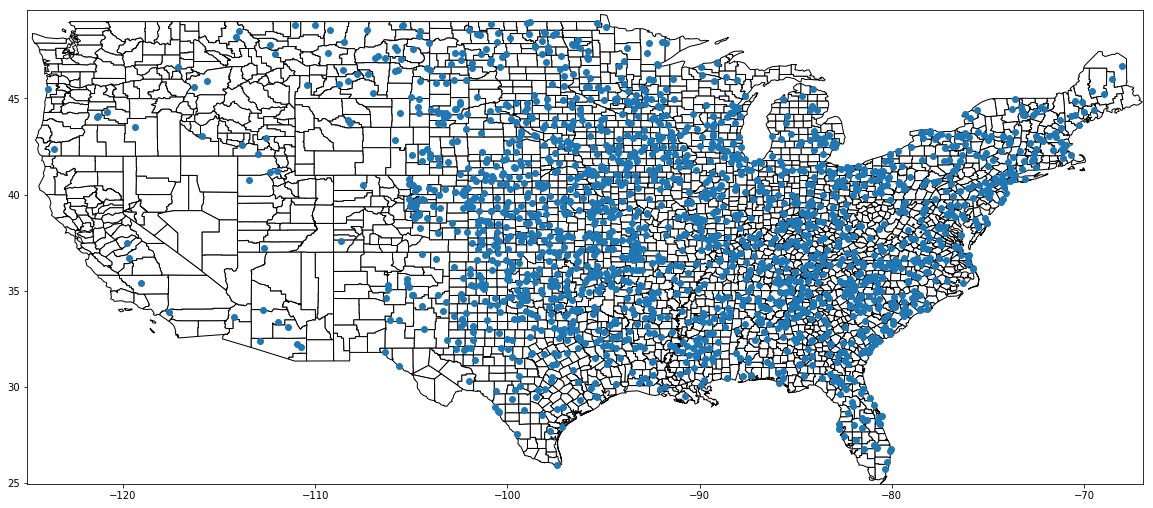

In [58]:
# Sample of 2000 storms in the Lower48
fig, ax = plt.subplots(figsize=(20,20))
counties.plot(ax=ax, color='white', edgecolor='black');
storms.sample(2000).plot(ax=ax, marker='o')
ax.set_xlim(-125.0011,-66.9326)
ax.set_ylim(24.9493, 49.5904)
plt.show()

Floods and tornadoes show basically the same distribution, so I won't plot them separately.  For reference, this is what the dataframes that we're about to export look like.

In [63]:
display(storms)

(622110, 3)


,EVENT_TYPE,year,geometry
0,Hail,1996,POINT (-98.03 34.42)
1,Thunderstorm Wind,1996,POINT (-97.15000000000001 31.55)
2,Thunderstorm Wind,1996,POINT (-88.97 36.02)
3,Thunderstorm Wind,1996,POINT (-89.06999999999999 40.53)
4,Thunderstorm Wind,1996,POINT (-87.06999999999999 39.92)


In [64]:
display(floods)

(78936, 3)


,EVENT_TYPE,year,geometry
0,Flood,2005,POINT (-78.02 39.47)
1,Flood,2005,POINT (-89.37 37.22)
2,Flash Flood,2005,POINT (-89.2 31.6)
3,Flood,2005,POINT (-79.43000000000001 41.22)
4,Flood,2005,POINT (-79.43000000000001 41.22)


In [67]:
display(tornadoes)

(30898, 3)


,year,geometry,intensity
0,1996,POINT (-89.87 36.18),1
1,1996,POINT (-90.97 34.55),1
2,1996,POINT (-92.31999999999999 30.57),1
3,1996,POINT (-86.97 40.5),0
4,1996,POINT (-96.15000000000001 33.72),2


# Export!

In [62]:
storms.to_file("../data_output/5__NOAA/storms.geojson",
                     driver='GeoJSON')
floods.to_file("../data_output/5__NOAA/floods.geojson",
                     driver='GeoJSON')
tornadoes.to_file("../data_output/5__NOAA/tornadoes.geojson",
                     driver='GeoJSON')